# Music Information Retrieval - Notebook



## Erkennen der Tonhöhe
Generierung eines Tons:

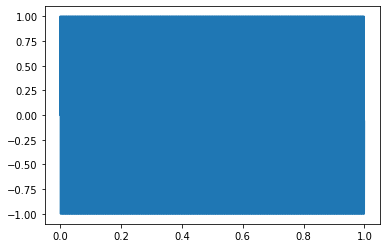

In [2]:
import numpy as np
from matplotlib import pyplot as plt

sr = 44100  # Hertz
duration = 1 # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

x, generated_wave = generate_sine_wave(440, sr, duration)
plt.plot(x, generated_wave)
plt.show()

Abspielen des Tons:

In [3]:
import IPython.display as ipd

ipd.Audio(data=generated_wave, rate=sr)

Fourier-Transformation:

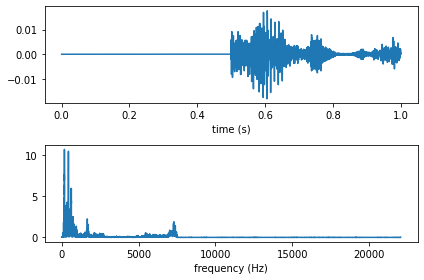

No pitch found


In [7]:
from scipy.io.wavfile import read
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
import soundfile as sf

def fourier_transform(wave):
    yf = rfft(wave)
    xf = rfftfreq(len(wave), 1 / sr)

    # plot:

    time = [None] * len(wave)
    for i in range(len(wave)):
        time[i] = i / sr

    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
    ax1.plot(time, wave)
    ax1.set_xlabel("time (s)")

    ax2.plot(xf,np.abs(yf))
    ax2.set_xlabel("frequency (Hz)")

    plt.tight_layout()
    plt.show()
    
    # Tonhöhe in Hertz:
    
    fourier = np.abs(yf)
    peaks = find_peaks(fourier, prominence=150)[0]
    try:
        pitch = peaks[0]
        print("Tonhöhe:", pitch, "Hertz")
    except IndexError:
        print("No pitch found")

recording, _ = sf.read('recording.wav')
fourier_transform(recording)

## Aufnehmen:

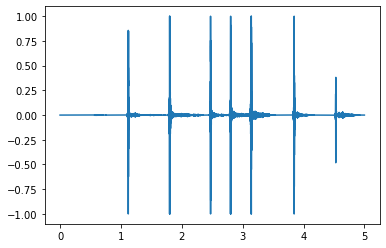

In [9]:
import soundfile as sf
import sounddevice as sd
from time import sleep
import scipy.io.wavfile
import IPython.display as ipd
from matplotlib import pyplot as plt

sr = 44100

def record(duration=1, file='recording.wav'):
    play_beep()
    recording = sd.rec(int(duration * sr), samplerate=sr, channels=1)
    sd.wait()
    play_beep()
    scipy.io.wavfile.write(file, sr, recording)
    
    # plot:
    
    time = [None] * len(recording)
    for i in range(len(recording)):
        time[i] = i / sr
    
    plt.plot(time, recording)
    plt.show
    
    
def play_beep():
    data, a = sf.read('beep.wav')
    sd.play(data, a)
    sleep(0.3)
    
record(5, 'recording.wav')
ipd.Audio(data='recording.wav', rate=44100)

## Onset detection

Anzahl der der Schläge: 7


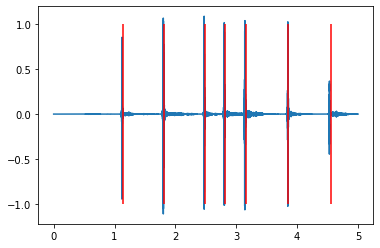

In [10]:
import librosa
import soundfile as sf

sr = 44100


x, sr = librosa.load('recording.wav')
onset_frames = librosa.onset.onset_detect(y=x, sr=sr, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
# print(onset_frames)
print("Anzahl der der Schläge:", len(onset_frames))
onset_times = librosa.frames_to_time(onset_frames)
# print(onset_times)
clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(x))

# plot:
    
time = [None] * len(x)
for i in range(len(x)):
    time[i] = i / sr
    
plt.plot(time, x)
plt.vlines(onset_times, -1, 1, color='r')
plt.show

# Audio

ipd.Audio(x + clicks, rate=sr)